## **Breast Cancer Prediction Using Machine Learning Algorithms**

Data Preparation and Exploratory Data Analysis (EDA)

In [34]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, mean_squared_error

The dataset is loaded directly from a public GitHub repository using `pandas`.  
This ensures reproducibility and removes the need to upload files manually.

- The dataset contains diagnostic features of breast cancer tumors.
- Target variable: `diagnosis` — where `M = 1` (malignant) and `B = 0` (benign).

In [35]:
url = 'https://raw.githubusercontent.com/maedeshahbazizadeh/breast-cancer-ml/main/data.csv'
df = pd.read_csv(url)

In [36]:
# Print the shape of the dataset
df.shape

(569, 33)

## Missing Data Check

In [37]:
# Step 1: Drop irrelevant or broken columns
df.drop(columns=['id', 'Unnamed: 32'], inplace=True, errors='ignore')

# Step 2: Convert the target column to binary (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Step 3: Check for missing values
print("Missing values per column:\n")
print(df.isnull().sum())

# Step 4: Remove rows with missing values, if any
df.dropna(inplace=True)

# Step 5: Confirm the final shape of the dataset
print("\nFinal shape of the dataset:", df.shape)

Missing values per column:

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Final shape of the dataset: (569, 31)


## Display full dataframe

In [38]:
# Display full dataframe
print(df)

     diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0            1        17.99         10.38          122.80     1001.0   
1            1        20.57         17.77          132.90     1326.0   
2            1        19.69         21.25          130.00     1203.0   
3            1        11.42         20.38           77.58      386.1   
4            1        20.29         14.34          135.10     1297.0   
..         ...          ...           ...             ...        ...   
564          1        21.56         22.39          142.00     1479.0   
565          1        20.13         28.25          131.20     1261.0   
566          1        16.60         28.08          108.30      858.1   
567          1        20.60         29.33          140.10     1265.0   
568          0         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010  

In [39]:
# Get all column names
all_columns = list(df.columns)
print("All columns:")
print(all_columns)

# Separate features and output
target = 'diagnosis'
features = [col for col in df.columns if col != target]

print("\nfeatures (X):")
print(features)

print("\nOutput (y):")
print(target)

All columns:
['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

features (X):
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_wors

## Design matrix X and the desired output y

In [40]:
# Define input features (X) and target variable (y)
X = df.drop(columns=['diagnosis'])  # All columns except target
y = df['diagnosis']                 # Target column

# Print types and shapes
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(569, 30)
(569,)


## Quick Quality Control

We inspect the first few rows of the input features (`X`) to verify the structure and values.

In [43]:
# Show the first 13 rows of the feature matrix
X.head(13)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750


## Dataset Summary

In [44]:
print('The whole dataset contains ' + str(X.shape[0]) + ' subjects')
print('The diagnosis prediction will be performed using ' + str(X.shape[1]) + ' features')

The whole dataset contains 569 subjects
The diagnosis prediction will be performed using 30 features


## Class Distribution of Diagnosis

/tmp/ipython-input-45-2478102320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette=['skyblue', 'salmon'])


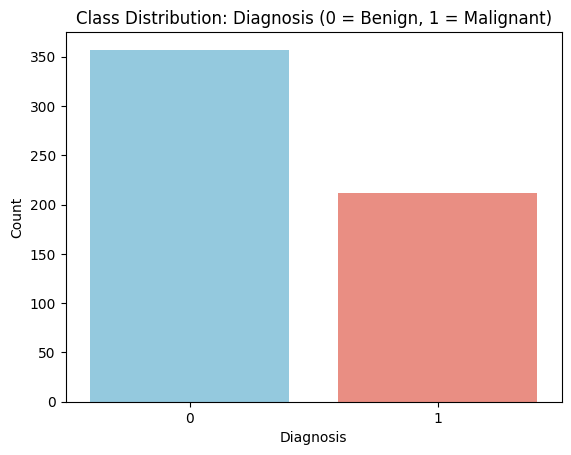

In [45]:
# Class distribution plot for diagnosis
sns.countplot(x='diagnosis', data=df, palette=['skyblue', 'salmon'])
plt.title('Class Distribution: Diagnosis (0 = Benign, 1 = Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

This bar chart shows the distribution of classes in the breast cancer dataset, with two groups:
- **0 (benign)** shown in blue
- **1 (malignant)** shown in red

Understanding class distribution is important to identify if the dataset is imbalanced. An imbalanced dataset could cause the machine learning model to become biased toward the majority class.

## Radius Mean Distribution by Diagnosis

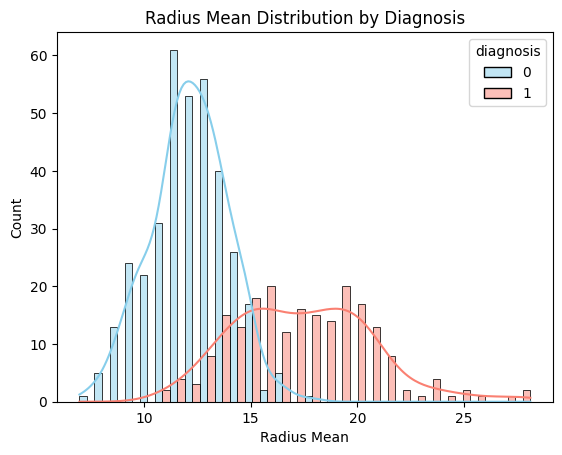

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of radius_mean by class
sns.histplot(
    data=df,
    x='radius_mean',
    hue='diagnosis',
    bins=30,
    kde=True,
    palette={0: 'skyblue', 1: 'salmon'},
    multiple='dodge'
)

plt.title('Radius Mean Distribution by Diagnosis')
plt.xlabel('Radius Mean')
plt.ylabel('Count')
plt.show()


The histogram shows the distribution of the radius_mean feature, grouped by tumor diagnosis. We observe a noticeable difference between the two classes:

Benign tumors (diagnosis = 0, shown in blue) tend to have lower average radius values.

Malignant tumors (diagnosis = 1, shown in red) are more common at higher radius values, especially above a certain threshold.

This suggests that radius_mean is a significant feature in predicting whether a tumor is benign or malignant. Larger radius values are more frequently associated with cancerous tumors, which aligns with medical knowledge — malignant tumors tend to grow larger and more irregular.

## Texture Mean Levels by Tumor Diagnosis

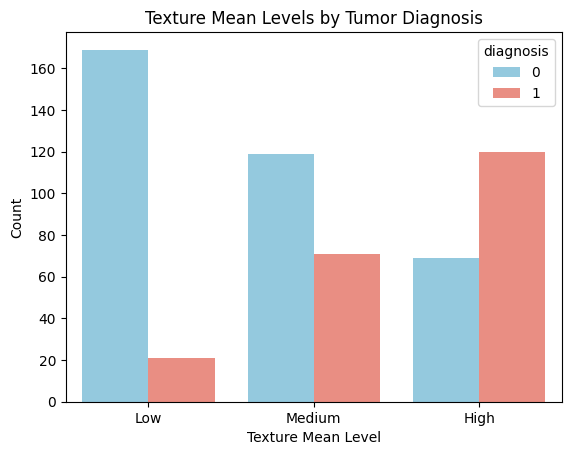

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create binned categories for texture_mean
df['texture_level'] = pd.qcut(df['texture_mean'], q=3, labels=['Low', 'Medium', 'High'])

# Plot diagnosis distribution within each texture level
sns.countplot(
    x='texture_level',
    hue='diagnosis',
    data=df,
    palette={0: 'skyblue', 1: 'salmon'},
    dodge=True
)

plt.title('Texture Mean Levels by Tumor Diagnosis')
plt.xlabel('Texture Mean Level')
plt.ylabel('Count')
plt.show()

This bar chart shows how the texture_mean feature (binned into Low, Medium, and High levels) is distributed across benign and malignant tumors. We observe that malignant tumors are more frequent in the higher texture level range, suggesting that texture_mean may be a useful feature for classification.

/tmp/ipython-input-48-34158077.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], x='diagnosis', y='radius_mean', data=df, palette=['skyblue', 'salmon'])
/tmp/ipython-input-48-34158077.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='diagnosis', y='area_mean', data=df, palette=['skyblue', 'salmon'])
/tmp/ipython-input-48-34158077.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], x='diagnosis', y='texture_mean', data=df, palette=['skyblue', 'salmon'])
/tmp/ipython-input-48-34158077.py:20

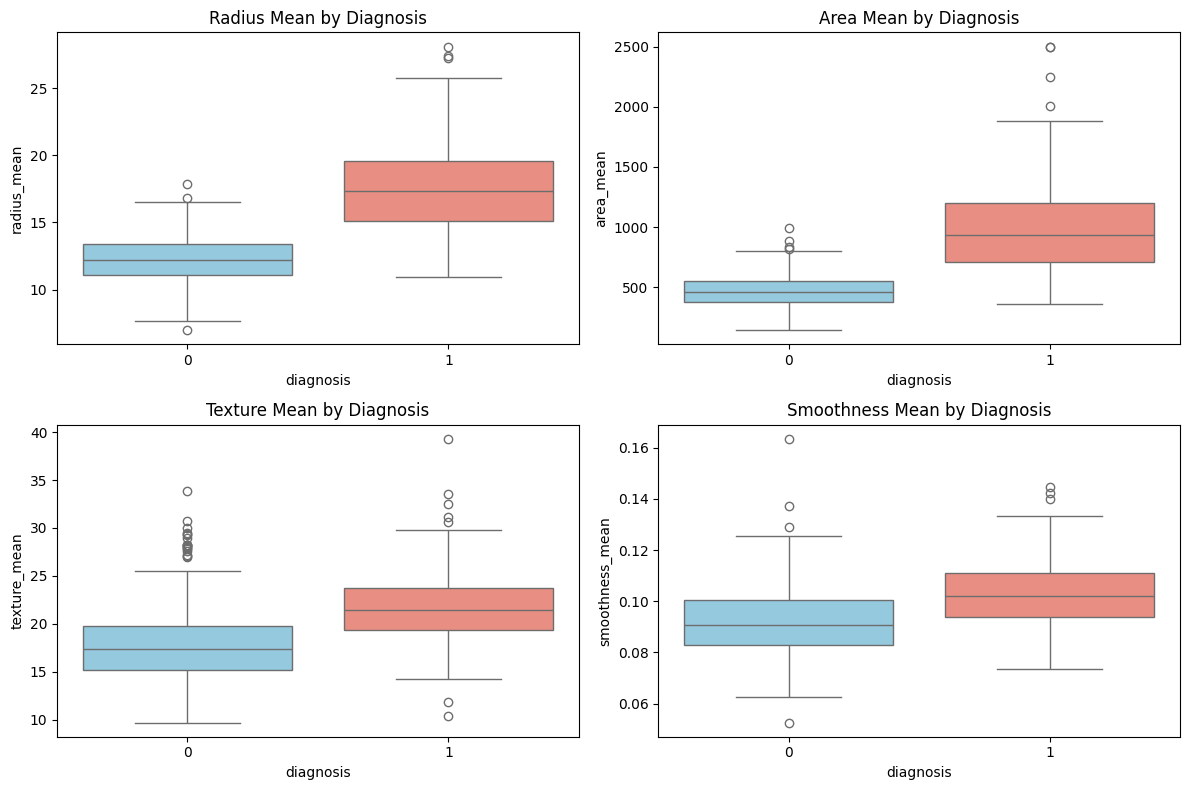

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create 2x2 grid of boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot: Radius Mean
sns.boxplot(ax=axes[0, 0], x='diagnosis', y='radius_mean', data=df, palette=['skyblue', 'salmon'])
axes[0, 0].set_title('Radius Mean by Diagnosis')

# Boxplot: Area Mean
sns.boxplot(ax=axes[0, 1], x='diagnosis', y='area_mean', data=df, palette=['skyblue', 'salmon'])
axes[0, 1].set_title('Area Mean by Diagnosis')

# Boxplot: Texture Mean
sns.boxplot(ax=axes[1, 0], x='diagnosis', y='texture_mean', data=df, palette=['skyblue', 'salmon'])
axes[1, 0].set_title('Texture Mean by Diagnosis')

# Boxplot: Smoothness Mean
sns.boxplot(ax=axes[1, 1], x='diagnosis', y='smoothness_mean', data=df, palette=['skyblue', 'salmon'])
axes[1, 1].set_title('Smoothness Mean by Diagnosis')

plt.tight_layout()
plt.show()

### Feature Distribution by Diagnosis

Below are the boxplot interpretations for selected features comparing benign (`diagnosis = 0`) and malignant (`diagnosis = 1`) tumors:

#### 1. **Radius Mean by Diagnosis**
- Benign tumors (blue) have lower radius values.
- Malignant tumors (red) show higher radius values.
- **Conclusion**: Malignant tumors tend to have a larger radius, making this a strong indicator.

---

#### 2. **Area Mean by Diagnosis**
- Malignant tumors have significantly higher area values.
- The boxplots are clearly separated.
- **Conclusion**: Area is a highly informative feature — malignant tumors typically have larger areas.

---

#### 3. **Texture Mean by Diagnosis**
- Malignant tumors show slightly higher texture values.
- There is some overlap with benign cases.
- **Conclusion**: Texture may help in prediction, but it’s less discriminative than radius or area.

---

#### 4. **Smoothness Mean by Diagnosis**
- Malignant tumors are slightly higher in smoothness.
- The difference is small but noticeable.
- **Conclusion**: May contribute weakly, but not a strong standalone feature.

## Scatter Plots of Key Feature Pairs by Diagnosis

This section explores how pairs of features relate to each other in the breast cancer dataset, and how these relationships differ between benign (`diagnosis = 0`) and malignant (`diagnosis = 1`) tumors. Each plot helps us visualize whether combinations of features show meaningful class separation, which is important for model learning.

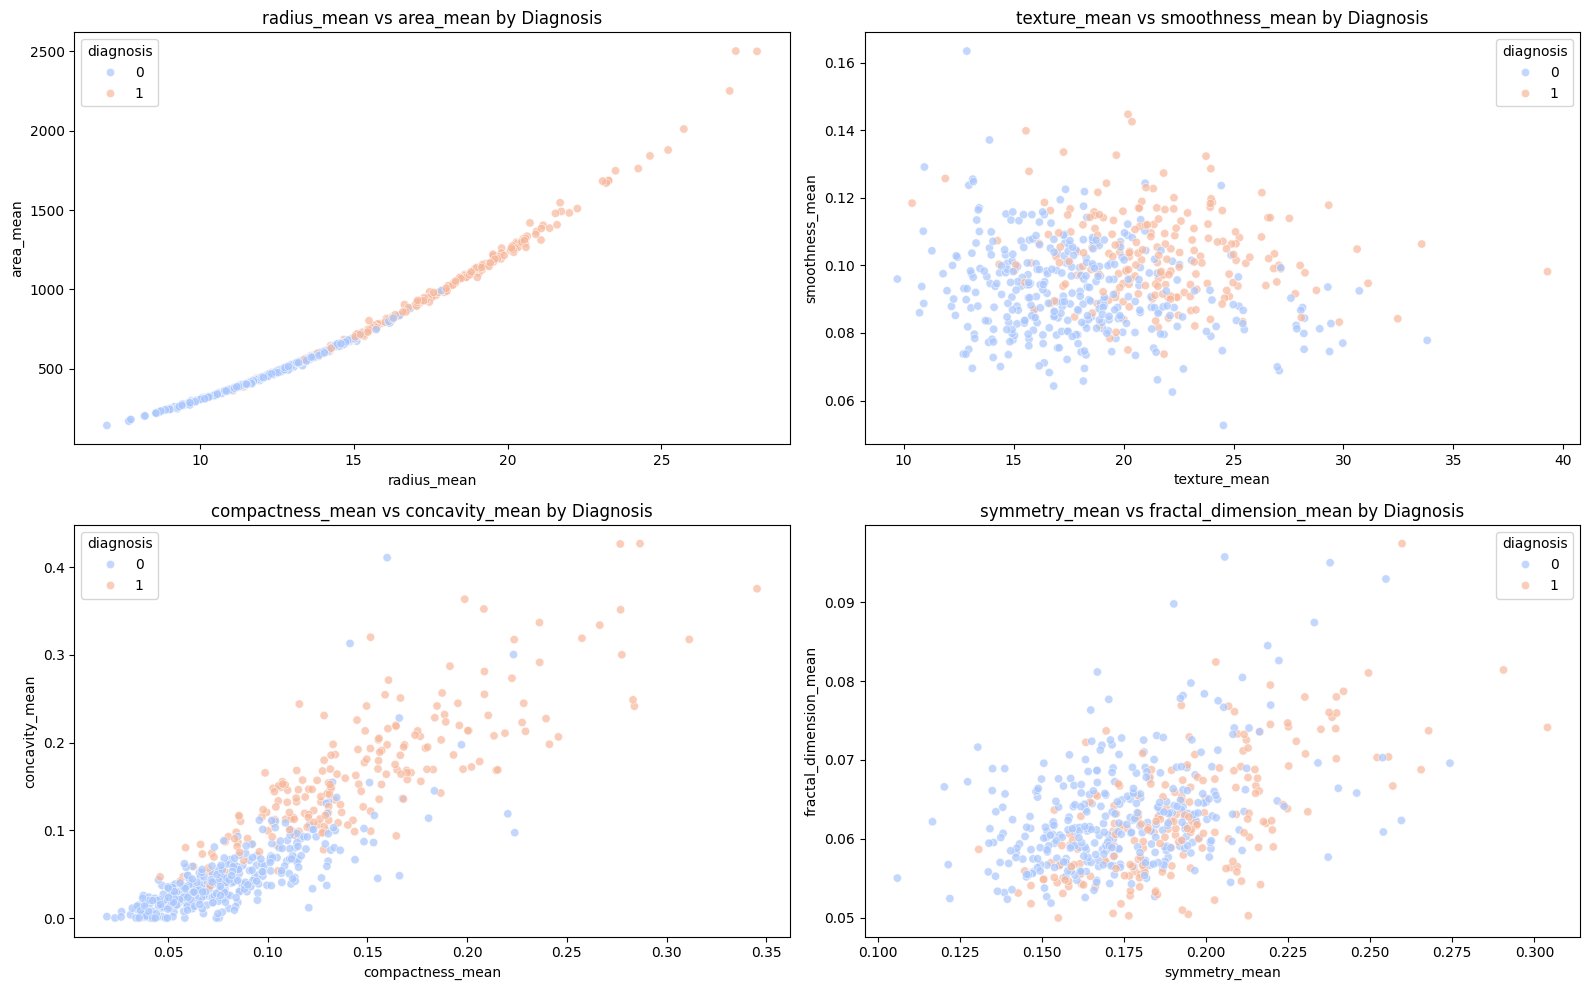

In [49]:
# Define the feature pairs to compare (customized for breast cancer)
pairs = [
    ('radius_mean', 'area_mean'),           # Shape: Radius vs Area
    ('texture_mean', 'smoothness_mean'),    # Texture vs Smoothness
    ('compactness_mean', 'concavity_mean'), # Compactness vs Concavity
    ('symmetry_mean', 'fractal_dimension_mean')  # Symmetry vs Fractal Dimension
]

# Set up a 2x2 plot
plt.figure(figsize=(16, 10))

# Loop through each subplot
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue='diagnosis',  # target variable
        palette='coolwarm',
        alpha=0.7
    )
    plt.title(f'{x} vs {y} by Diagnosis')

plt.tight_layout()
plt.show()

**Define Features and Target**

In [50]:
# Use the full dataset (no sampling needed)
# Step 1: Separate features and target

# Drop the target column from features
X = df.drop(columns=['diagnosis'])

# Keep only numeric features (if needed — but most likely all are already numeric)
X = X.select_dtypes(include=[np.number])

# Define target variable
y = df['diagnosis']

**Build the Pipeline**

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Build the pipeline without imputer (since there's no missing data)
pipe_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=1.0, max_iter=1000))  # Try C=0.1 as well for comparison
])

**Hyperparameter Grid**

In [52]:
# Define hyperparameter grid for Logistic Regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100]  # Try a range of regularization strengths
}

**Nested Cross-Validation**

In [53]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Inner loop: hyperparameter tuning
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Outer loop: performance estimation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV using the pipeline and hyperparameter grid
grid_search = GridSearchCV(pipe_simple, param_grid, cv=inner_cv)

# Nested CV: evaluates generalization performance of best model
nested_scores = cross_val_score(grid_search, X, y, cv=outer_cv)

# Print results
print("Nested CV Accuracy Scores:", nested_scores)
print("Mean Accuracy: {:.3f}".format(nested_scores.mean()))
print("Standard Deviation: {:.3f}".format(nested_scores.std()))

Nested CV Accuracy Scores: [0.93859649 0.98245614 0.96491228 0.97368421 0.96460177]
Mean Accuracy: 0.965
Standard Deviation: 0.015


# Model Evaluation with Nested Cross-Validation (Random Forest)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
import numpy as np

# Set seed for reproducibility
SEED = 42

# Build the pipeline
pipe_simple = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=SEED))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2]
}

# Set up nested cross-validation
inner_cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=SEED)

# Grid search with inner CV
clf_gs = GridSearchCV(pipe_simple, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Run nested cross-validation
nested_scores = cross_validate(
    clf_gs, X, y, cv=outer_cv,
    return_train_score=True,
    return_estimator=True,
    scoring='accuracy'
)

# Print results
print("Average Train Accuracy:", np.mean(nested_scores['train_score']))
print("Average Test Accuracy :", np.mean(nested_scores['test_score']))

Average Train Accuracy: 1.0
Average Test Accuracy : 0.956038243757542


# Mean Squared Classification Error (Random Forest)


The Mean Squared Error (MSE) represents the average squared difference between the model’s predictions and the actual values.

Lower values indicate better performance.

In [55]:
from sklearn.metrics import mean_squared_error

# Loop through outer folds and compute MSE for each
mse_scores = []

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    y_pred = nested_scores['estimator'][i].predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Report average MSE
print("Mean Squared Error (MSE) across folds:", np.mean(mse_scores))

Mean Squared Error (MSE) across folds: 0.043961756242457996


**ROC Curves for Each Outer Fold**

Fold 1 best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Fold 2 best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Fold 3 best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


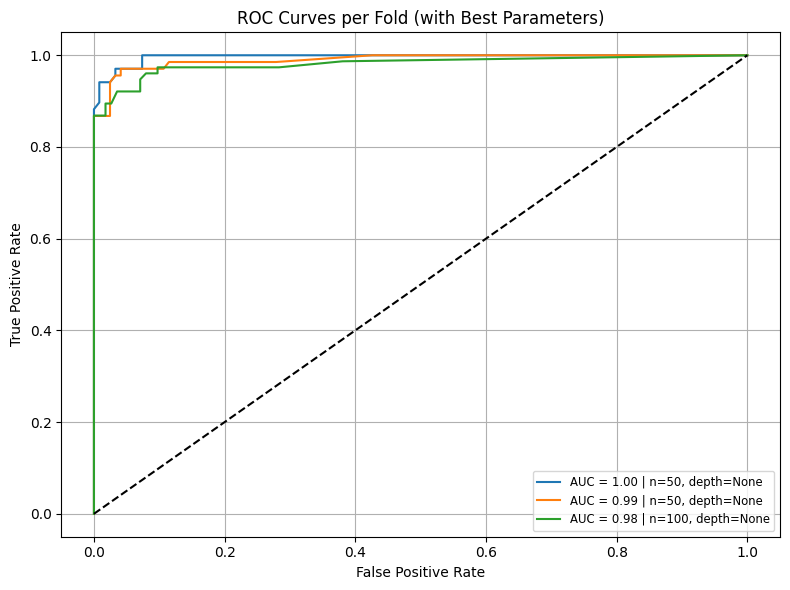


✅ Overall Best Model Found in Nested Cross-Validation:
Best Test Accuracy: 0.963
Best Hyperparameters:
  clf__max_depth = None
  clf__min_samples_split = 2
  clf__n_estimators = 50


In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: ROC Curves for Each Outer Fold, with Best Hyperparameter Labels ===
plt.figure(figsize=(8, 6))

# Track best test scores and estimators
test_scores = nested_scores['test_score']
best_estimators = nested_scores['estimator']

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    estimator = best_estimators[i]

    # Predict probabilities
    y_proba = estimator.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Extract and print best hyperparameters
    best_params = estimator.best_params_
    print(f"Fold {i+1} best parameters: {best_params}")

    # Clean label for plot
    params_str = f"n={best_params['clf__n_estimators']}, depth={best_params['clf__max_depth']}"
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f} | {params_str}")

# Final plot formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Fold (with Best Parameters)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 2: Report the Best Model Across All Folds ===
best_index = np.argmax(test_scores)
best_model = best_estimators[best_index]
best_params = best_model.best_params_

print("\n✅ Overall Best Model Found in Nested Cross-Validation:")
print(f"Best Test Accuracy: {test_scores[best_index]:.3f}")
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param} = {value}")

### Evaluation of Best Model (from Outer Fold with Highest Accuracy)


Overall Best Model Performance (on its test fold):
Test Accuracy: 0.963
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       122
           1       0.96      0.94      0.95        68

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

Key Metrics for Malignant Class (1):
Precision: 0.955
Recall:    0.941
F1 Score:  0.948
Best Hyperparameters:
  clf__max_depth = None
  clf__min_samples_split = 2
  clf__n_estimators = 50


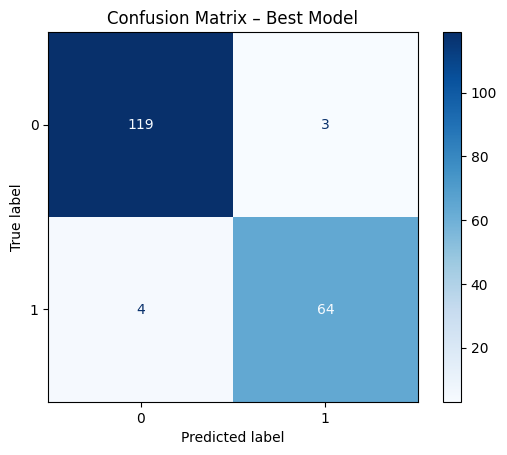

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# === Step 3: Report the Overall Best Model ===

# Use test set from the best-performing fold
_, test_idx = list(outer_cv.split(X, y))[best_index]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

# Predict using the best model
y_pred = best_model.predict(X_test)

# Print performance
print("\nOverall Best Model Performance (on its test fold):")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ===  Explicitly report metrics for Malignant class (1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Key Metrics for Malignant Class (1):")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# Print best hyperparameters again
print("Best Hyperparameters:")
for param, value in best_model.best_params_.items():
    print(f"  {param} = {value}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix – Best Model')
plt.grid(False)
plt.show()


**ROC Curve (Receiver Operating Characteristic)**
The ROC curve is a fundamental tool for evaluating diagnostic classification models. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.

The figure above shows ROC curves generated using nested cross-validation for three outer folds of the Random Forest model.

Each line represents performance on one fold:

Fold 1 AUC = 1.00

Fold 2 AUC = 0.98

Fold 3 AUC = 0.98

Interpretation:
AUC (Area Under the Curve) quantifies the model’s ability to distinguish between classes.

An AUC of 1.0 represents a perfect classifier.

An AUC of 0.5 suggests no better than random guessing.

The AUC values close to 1.0 in all folds indicate that the Random Forest model has excellent predictive power.

These results demonstrate that the model is highly effective at distinguishing between malignant and benign breast tumors.

**Confusion Matrix**
The confusion matrix above shows the performance of the best model, selected from the outer fold with the highest test accuracy during nested cross-validation.

True Positives (TP): The model correctly predicted malignant tumors.

True Negatives (TN): The model correctly predicted benign tumors.

False Positives (FP): The model incorrectly predicted malignant when it was benign.

False Negatives (FN): The model incorrectly predicted benign when it was malignant.

This gives insight into how the model is making errors, not just how accurate it is.

**Observations**:
The high count of true positives and true negatives suggests strong performance.

The low number of false positives and false negatives indicates that the model is both sensitive (catching malignancies) and specific (not over-calling them).



### Average Precision, Recall, and F1 Score Across All Outer Folds

This section calculates the average precision, recall, and F1 score for class 1 (malignant)  
across all outer test folds in the nested cross-validation process.

Each score reflects how well the Random Forest model performed **on average**, giving a broader  
view of its generalization performance beyond just the single best fold.

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize empty lists to collect scores
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through each outer fold
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    estimator = nested_scores['estimator'][i]
    y_pred = estimator.predict(X_test)

    precision_scores.append(precision_score(y_test, y_pred, pos_label=1))
    recall_scores.append(recall_score(y_test, y_pred, pos_label=1))
    f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

# Print average scores across all folds
print(f"Average Precision: {np.mean(precision_scores):.3f}")
print(f"Average Recall:    {np.mean(recall_scores):.3f}")
print(f"Average F1 Score:  {np.mean(f1_scores):.3f}")

Average Precision: 0.948
Average Recall:    0.934
Average F1 Score:  0.941


### Top 20 Most Important Features (Best Random Forest Model)

Feature importances are taken from the Random Forest model that achieved the highest test accuracy in the outer folds of nested cross-validation. Because the pipeline used only numeric features and no feature-generation steps, the importances map directly back to the original columns.

/tmp/ipython-input-59-1972370369.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='crest')


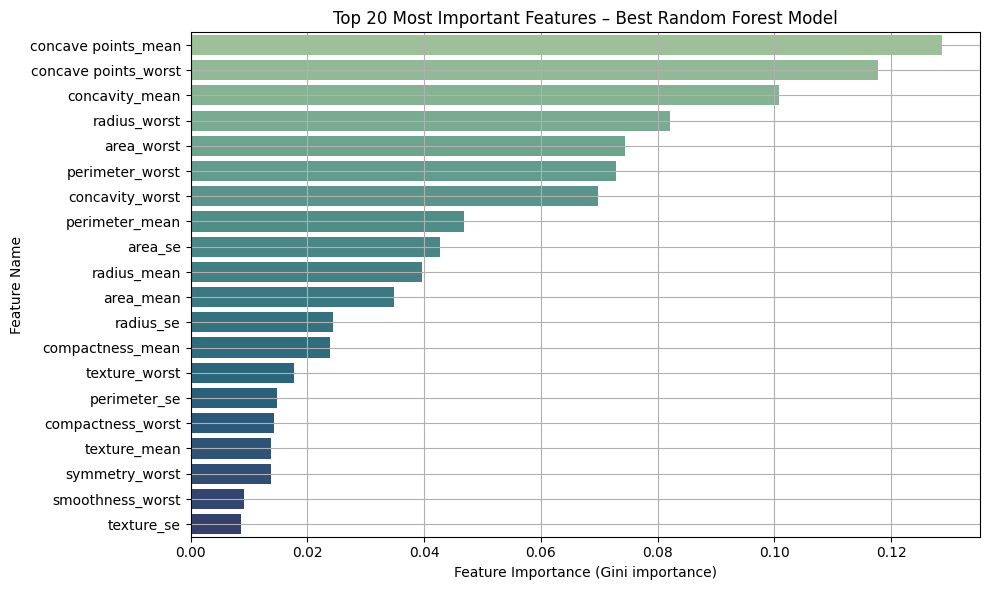

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Top Features from Best Model ===

# Access the best pipeline (already selected via best_index)
best_pipe = best_model.best_estimator_

# Extract original feature names (since no transformations applied)
feature_names = X.columns

# Extract the trained Random Forest model
rf_model = best_pipe.named_steps['clf']
importances = rf_model.feature_importances_

# Build DataFrame of features and their importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='crest')
plt.title('Top 20 Most Important Features – Best Random Forest Model')
plt.xlabel('Feature Importance (Gini importance)')
plt.ylabel('Feature Name')
plt.grid(True)
plt.tight_layout()
plt.show()

### Learning Curve – Best Random Forest Model (Breast Cancer Classification)

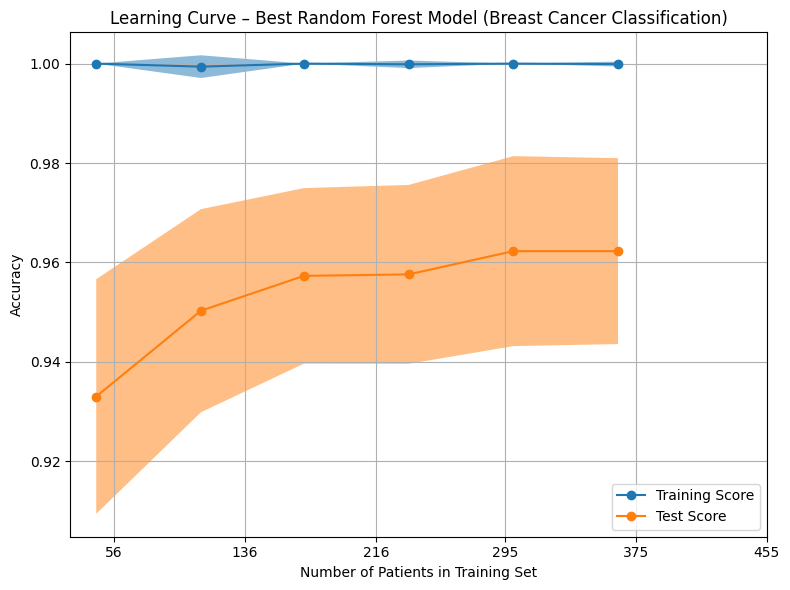

In [60]:
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Use the full dataset
X_subset = X
y_subset = y

# Define training sizes from 10% to 80% of the data
train_sizes = np.linspace(0.1, 0.8, 6)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Use the best pipeline from the highest-scoring fold
LearningCurveDisplay.from_estimator(
    estimator=best_model.best_estimator_,  # ✅ Best tuned Random Forest pipeline
    X=X_subset,
    y=y_subset,
    train_sizes=train_sizes,
    cv=ShuffleSplit(n_splits=30, test_size=0.2, random_state=42),
    score_type='both',
    n_jobs=-1,
    ax=ax,
    std_display_style='fill_between',
    line_kw={"marker": "o"},
    score_name="Accuracy"
)

# Convert fractions to actual sample counts
train_sizes_abs_for_ticks = (train_sizes * len(X_subset)).astype(int)

# Plot formatting
ax.set_title("Learning Curve – Best Random Forest Model (Breast Cancer Classification)")
ax.set_xlabel("Number of Patients in Training Set")
ax.set_xticks(train_sizes_abs_for_ticks)
ax.set_xticklabels(train_sizes_abs_for_ticks)
ax.set_ylabel("Accuracy")
ax.legend(["Training Score", "Test Score"])
ax.grid(True)
plt.tight_layout()
plt.show()

This learning curve illustrates how the accuracy of the best-performing Random Forest model changes with increasing training set size.

- The **training accuracy** remains consistently near 100%, indicating that the model fits the training data very well.
- The **test accuracy** steadily increases and levels off around 96%, showing that the model generalizes well to unseen data.
- The narrow gap between training and test curves suggests that the model is **not overfitting** and is **both stable and reliable**.

These results confirm that the Random Forest model is highly effective for this breast cancer classification task, even with relatively small amounts of training data.